In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import lacroix

import xclimate as xclim

In [ ]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [ ]:
nonglc_pct_threshold = 80
grid = xclim.load_fhist_ppe_grid()
nonglc_mask = grid.PCT_GLC < nonglc_pct_threshold

In [ ]:
variable_names = ["EFLX_LH_TOT", "FGEV", "FCTR", "FCEV", "TLAI", "FSH", "FSH_TO_COUPLER"]
time_slice = slice("1995-01", "2014-12")

fhist = {}
variables = []
for v in variable_names:
    print(v)
    key = f"{v}_month_1"
    fhist[key] = xclim.load_fhist(key, keep_var_only=True)[v].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    variables.append(key)

In [ ]:
delta = {}
for v in variables:
    delta[v] = fhist[v].sel(member=slice(1, None)) - fhist[v].sel(member=0)

dtmean = {}
for v in variables:
    dtmean[v] = delta[v].weighted(delta[v].time.dt.days_in_month).mean(dim="time")

dgmean = {}
for v in variables:
    dgmean[v] = dtmean[v].weighted(grid.LANDAREA).mean(dim=["lat", "lon"]).load()

dzmean = {}
for v in variables:
    dzmean[v] = dtmean[v].mean(dim=["lon"]).load()

In [ ]:
member = delta[v].member.values
n_member = len(member)

In [ ]:
colors = {
    "FCEV_month_1": "#0055A4",
    "FGEV_month_1": "#E88C00",
    "FCTR_month_1": "#009A90",
    "EFLX_LH_TOT_month_1": "#001563",
    "FSH_month_1": "#EF5116",
}

In [ ]:
m = 1

fig, ax = plt.subplots()
ax.axhline(0, c="k", lw=0.8)
ax.bar(
    x=np.arange(5),
    height=[
        dgmean["FCEV_month_1"].sel(member=m),
        dgmean["FGEV_month_1"].sel(member=m),
        dgmean["FCTR_month_1"].sel(member=m),
        dgmean["EFLX_LH_TOT_month_1"].sel(member=m),
        dgmean["FSH_month_1"].sel(member=m),
    ],
    color=[
        colors["FCEV_month_1"],
        colors["FGEV_month_1"],
        colors["FCTR_month_1"],
        colors["EFLX_LH_TOT_month_1"],
        colors["FSH_month_1"],
    ],
    alpha=0.8,
)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["FCEV", "FGEV", "FCTR", "LH", "SH"])
ax.set_ylabel("Evaporative Flux [W/m2]")
ax.set_title(xclim.ppe.get_member_name(m))

In [ ]:
subset = [1, 2, 7, 8, 15, 16]
n_subset = len(subset)

In [ ]:
fig, ax = plt.subplots(ncols=n_subset, nrows=1, sharex=False, sharey=False, figsize=(13, 2.5), layout="constrained", dpi=300)

xticklabels = ["FCEV", "FGEV", "FCTR", "LH"]

for i, m in enumerate(subset):
    x = [0, 1, 2, 3]
    y = [
        dgmean["FCEV_month_1"].sel(member=m),
        dgmean["FGEV_month_1"].sel(member=m),
        dgmean["FCTR_month_1"].sel(member=m),
        dgmean["EFLX_LH_TOT_month_1"].sel(member=m),
    ]
    c = [
        colors["FCEV_month_1"],
        colors["FGEV_month_1"],
        colors["FCTR_month_1"],
        colors["EFLX_LH_TOT_month_1"],
    ]
    l = ["FCEV", "FGEV", "FCTR", "ET"]
    ax[i].axhline(0, c="k", lw=0.8)
    ax[i].bar(x=x, height=y, color=c, label=l, alpha=0.8)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(xticklabels, rotation=45, ha="right")
    xclim.plot.center_axis_at_zero(ax[i])
    if i % n_subset == 0:
        ax[i].set_ylabel("$\\Delta$ Evap. Flux [W/m$^2$]", fontsize=10)
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=2, loc='lower right', bbox_to_anchor=(0.525, -0.25), fontsize=10)

In [ ]:
fig, ax = plt.subplots(ncols=n_subset, nrows=1, sharex=False, sharey=False, figsize=(13, 2.5), layout="constrained", dpi=300)

for i, m in enumerate(subset):
    dzmean["FCEV_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCEV_month_1"], label="FCEV", _labels=False)
    dzmean["FGEV_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FGEV_month_1"], label="FGEV", _labels=False)
    dzmean["FCTR_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCTR_month_1"], label="FCTR", _labels=False)
    dzmean["EFLX_LH_TOT_month_1"].sel(member=m).plot(ax=ax[i], y="lat", lw=2, c=colors["EFLX_LH_TOT_month_1"], label="LH", _labels=False)
    xclim.plot.center_axis_at_zero(ax[i], axis="x")
    ax[i].set_ylim(-55, 75)
    ax[i].set_yticks([-30, 0, 30, 60], minor=False)
    ax[i].set_yticks([-45, -15, 15, 45,75], minor=True)
    ax[i].grid(which="both")
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)
    ax[i].set_xlabel("$\\Delta$ Evap. Flux [W/m2]", fontsize=10)
    if i % n_subset == 0:
        ax[i].set_ylabel("Latitude [degN]", fontsize=10)

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncols=1, loc='lower right', bbox_to_anchor=(0.49, 0.09), fontsize=10)

In [ ]:
fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["EFLX_LH_TOT_month_1"].sel(member=subset),
    dim="member",
    label=f"$\\Delta$ET [W/m2]",
    robust=True,
    cmap="BrBG",
    ncol=6,
    vmin=-8,
    vmax=8,
)
fig.set_dpi(300)

fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["FCTR_month_1"].sel(member=subset),
    dim="member",
    label=f"$\\Delta$FCTR [W/m2]",
    robust=True,
    cmap="BrBG",
    ncol=6,
    vmin=-8,
    vmax=8,
)
fig.set_dpi(300)

fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["FGEV_month_1"].sel(member=subset),
    dim="member",
    label=f"$\\Delta$FGEV [W/m2]",
    robust=True,
    cmap="BrBG",
    ncol=6,
    vmin=-8,
    vmax=8,
)
fig.set_dpi(300)

fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["FCEV_month_1"].sel(member=subset),
    dim="member",
    label=f"$\\Delta$Evap. Flux [W/m2]",
    robust=True,
    cmap="BrBG",
    ncol=6,
    vmin=-8,
    vmax=8,
)
fig.set_dpi(300)

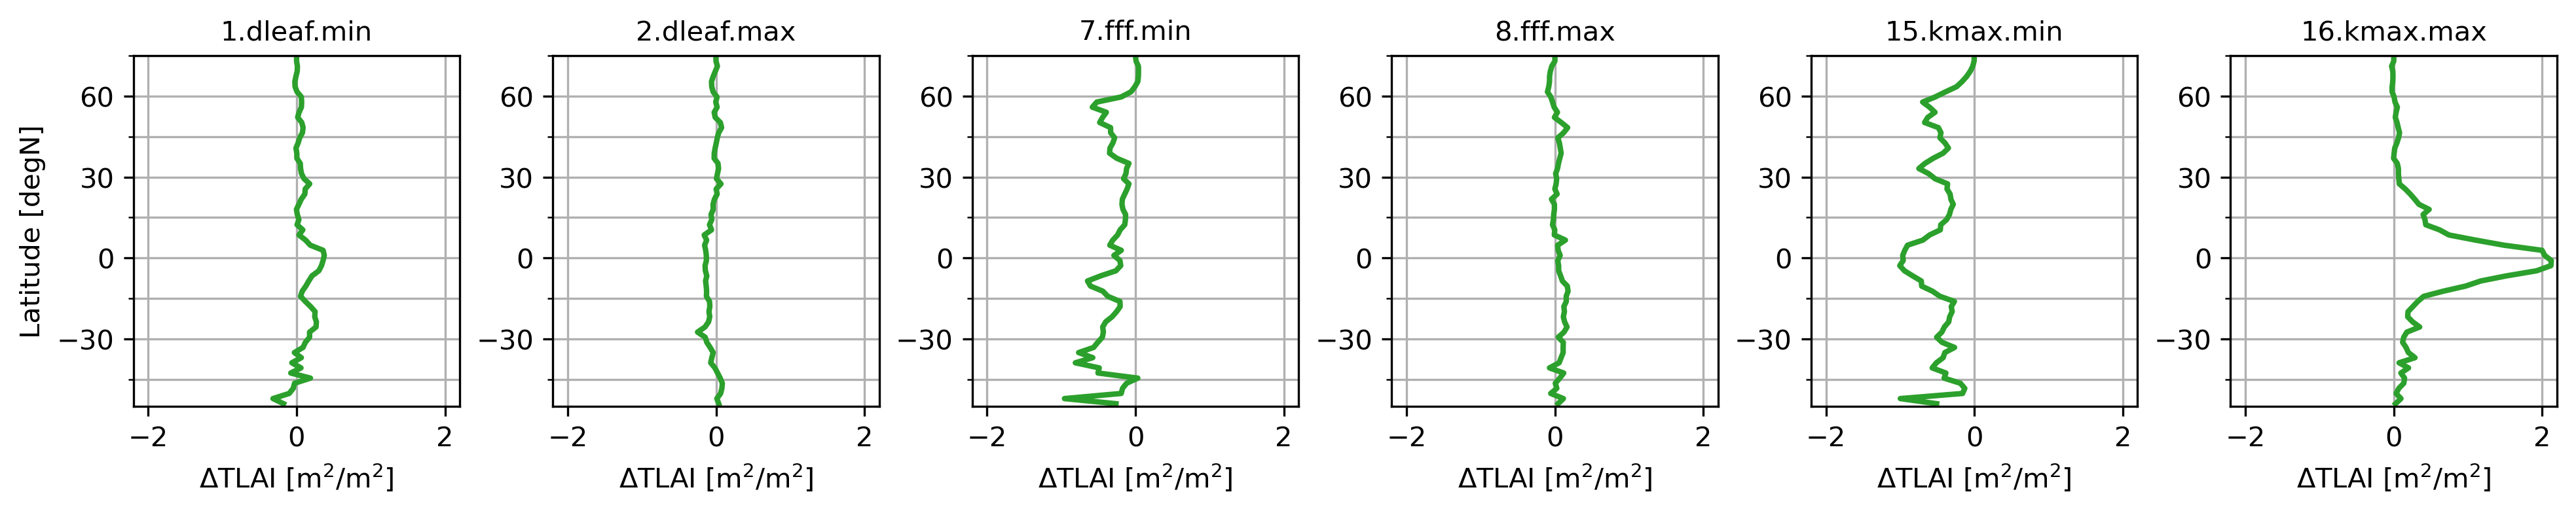

In [85]:
fig, ax = plt.subplots(ncols=n_subset, nrows=1, sharex=False, sharey=False, figsize=(13, 2.5), layout="constrained", dpi=300)

for i, m in enumerate(subset):
    dzmean["TLAI_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c="tab:green", label="TLAI", _labels=False)
    xclim.plot.center_axis_at_zero(ax[i], axis="x")
    ax[i].set_xlim(-2.2, 2.2)
    ax[i].set_ylim(-55, 75)
    ax[i].set_yticks([-30, 0, 30, 60], minor=False)
    ax[i].set_yticks([-45, -15, 15, 45,75], minor=True)
    ax[i].grid(which="both")
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)
    ax[i].set_xlabel("$\\Delta$TLAI [m$^2$/m$^2$]", fontsize=10)
    if i % n_subset == 0:
        ax[i].set_ylabel("Latitude [degN]", fontsize=10)

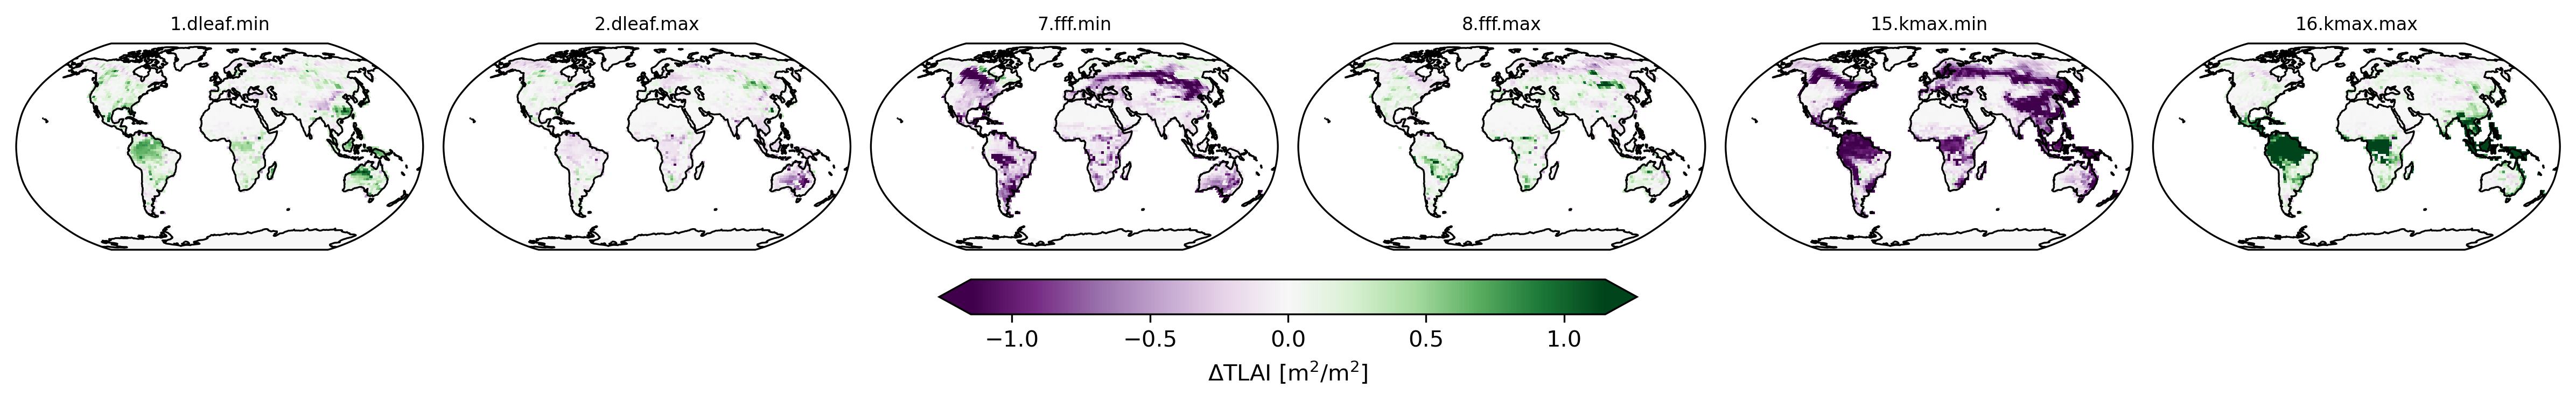

In [66]:
fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["TLAI_month_1"].sel(member=subset),
    dim="member",
    label=f"$\\Delta$TLAI [m$^2$/m$^2$]",
    robust=True,
    cmap="PRGn",
    ncol=6,
)
fig.set_dpi(300)

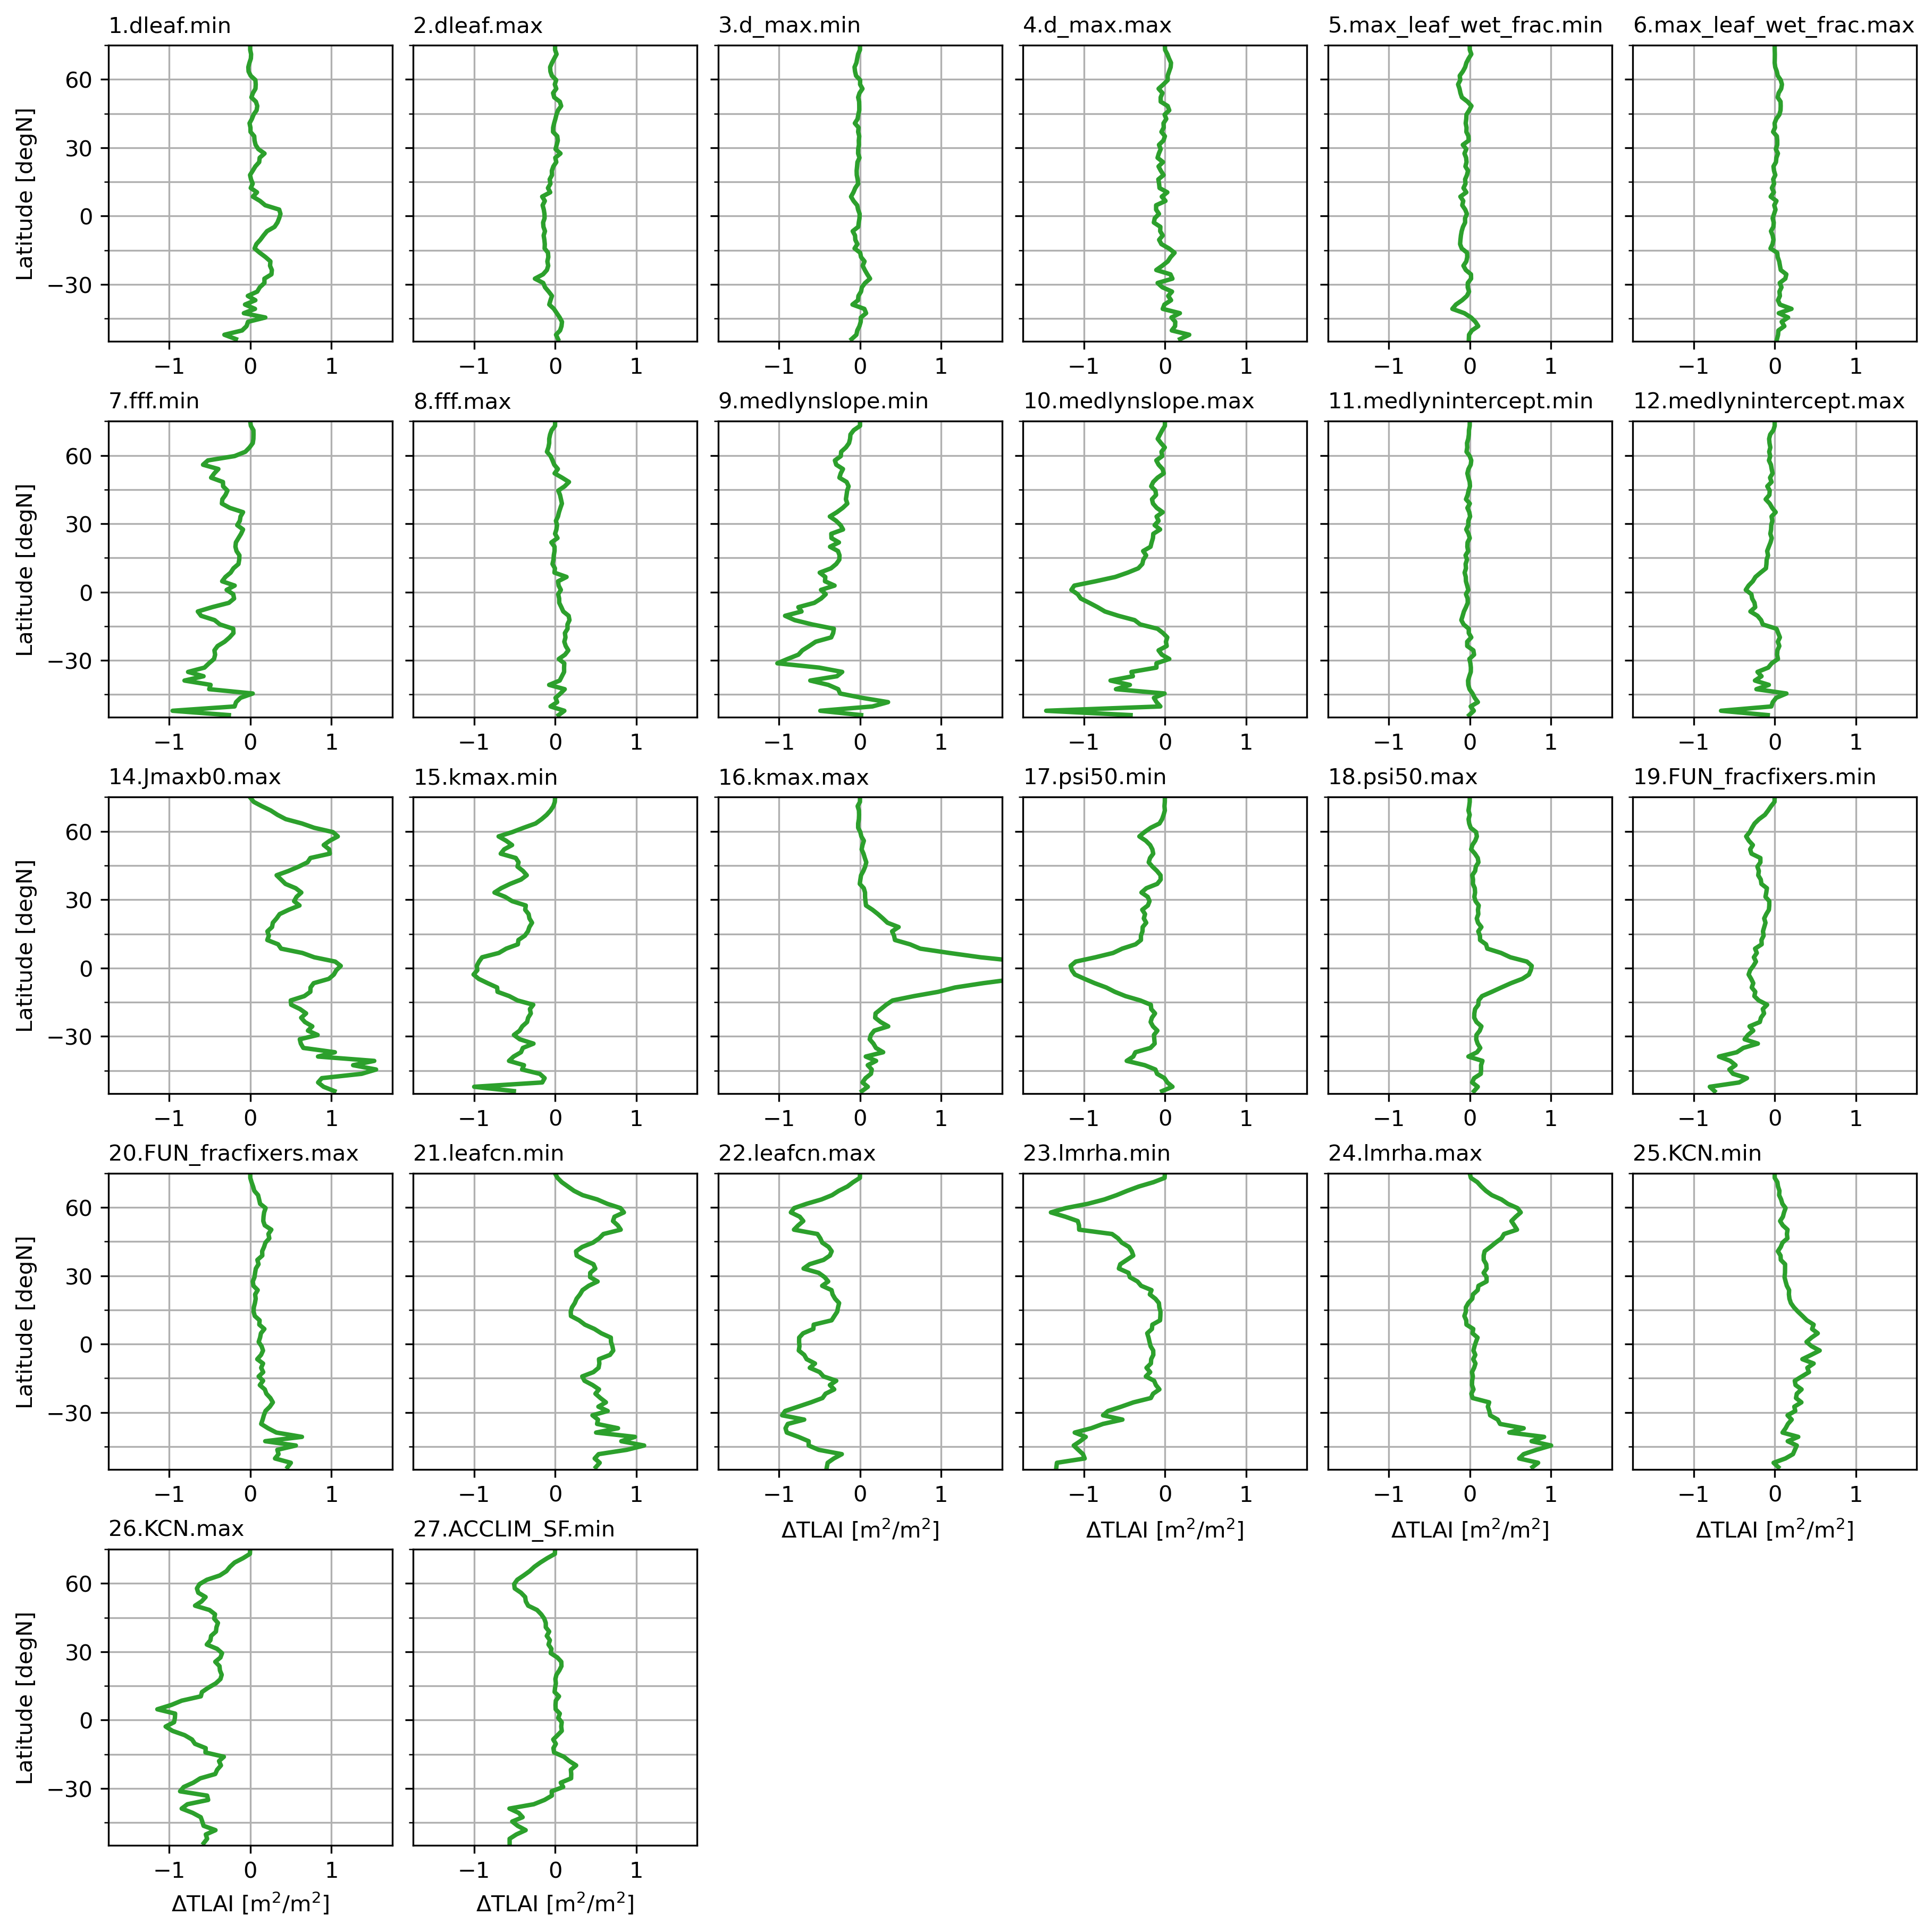

In [82]:
ncols = 6
nrows = 5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=True, figsize=(12, 12), layout="constrained", dpi=300)
ax = axs.flatten()

for i, m in enumerate(member):
    dzmean["TLAI_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c="tab:green", label="TLAI", _labels=False)
    xclim.plot.center_axis_at_zero(ax[i], axis="x")
    ax[i].set_xlim(-1.75, 1.75)
    ax[i].set_ylim(-55, 75)
    ax[i].set_yticks([-30, 0, 30, 60], minor=False)
    ax[i].set_yticks([-45, -15, 15, 45,75], minor=True)
    ax[i].grid(which="both")
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10, loc="left")
    if i % ncols == 0:
        ax[i].set_ylabel("Latitude [degN]", fontsize=10)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel("$\\Delta$TLAI [m$^2$/m$^2$]", fontsize=10)

for i in range(n_member, ncols * nrows):
    ax[i].remove()

# Force constrained layout to finalize positions
fig.canvas.draw()

# Add xlabels to second-to-last row where no subplot exists below
# add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$ Evap Flux [W/m2]", fontsize=10)
xclim.plot.add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$TLAI [m$^2$/m$^2$]", fontsize=10)


In [ ]:
fig, ax = xclim.plot.plot_facetgrid_map(
    da=dtmean["TLAI_month_1"],
    dim="member",
    label=f"$\\Delta$TLAI [m$^2$/m$^2$]",
    robust=True,
    cmap="PRGn",
    ncol=6,
)
fig.set_dpi(300)

---

In [ ]:
ncols = 6
nrows = 5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=True, figsize=(13, 12), layout="constrained")
ax = axs.flatten()

xticklabels = ["FCEV", "FGEV", "FCTR", "LH", "SH"]

for i, m in enumerate(member):
    x = [0, 1, 2, 3.5, 4.5]
    xvline = 2.75
    y = [
        dgmean["FCEV_month_1"].sel(member=m),
        dgmean["FGEV_month_1"].sel(member=m),
        dgmean["FCTR_month_1"].sel(member=m),
        dgmean["EFLX_LH_TOT_month_1"].sel(member=m),
        dgmean["FSH_month_1"].sel(member=m),
    ]
    c = [
        colors["FCEV_month_1"],
        colors["FGEV_month_1"],
        colors["FCTR_month_1"],
        colors["EFLX_LH_TOT_month_1"],
        colors["FSH_month_1"],
    ]
    l = ["FCEV", "FGEV", "FCTR", "LH", "SH"]
    ax[i].axhline(0, c="k", lw=0.8)
    ax[i].bar(x=x, height=y, color=c, label=l, alpha=0.8)
    ax[i].axvline(x=xvline, c="k", lw=0.8, ls="--")
    ax[i].set_xticks(x)
    ax[i].set_xticklabels([])
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)

    if i % ncols == 0:
        ax[i].set_ylabel("$\\Delta$ Energy Flux [W/m2]", fontsize=12)
    if i // ncols == nrows - 1:
        ax[i].set_xticklabels(xticklabels, rotation=60, ha="right")

for i in range(len(member), ncols * nrows):
    ax[i].remove()

# add_orphan_xticklabels(fig, ax, len(member), ncols, nrows, xticklabels, use_fig_text=True, rotation=60, ha="right")
xclim.plot.add_orphan_xticklabels(fig, ax, len(member), ncols, nrows, xticklabels, use_fig_text=True, rotation=60, ha="right")

handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncols=2, loc='lower right', bbox_to_anchor=(0.5, 0.08), fontsize=10) 
fig.legend(handles, labels, ncols=2, loc='lower right', bbox_to_anchor=(0.525, 0.08), fontsize=10)

# plt.savefig("/glade/work/bbuchovecky/et_controls/fig/d.globalmean.lnd.1995-2014.FHIST.ET-part.png", dpi=300, bbox_inches="tight")
plt.savefig("/glade/work/bbuchovecky/et_controls/fig/d.globalmean.lnd.1995-2014.FHIST.ET-part-shared.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
ax.axhline(0, c="gray", lw=0.8)
dzmean["FCEV_month_1"].isel(member=0).plot(ax=ax, label="FCEV", _labels=False, color=colors["FCEV_month_1"], lw=2)
dzmean["FGEV_month_1"].isel(member=0).plot(ax=ax, label="FGEV", _labels=False, color=colors["FGEV_month_1"], lw=2)
dzmean["FCTR_month_1"].isel(member=0).plot(ax=ax, label="FCTR", _labels=False, color=colors["FCTR_month_1"], lw=2)
dzmean["EFLX_LH_TOT_month_1"].isel(member=0).plot(ax=ax, label="EFLX_LH_TOT", _labels=False, c=colors["EFLX_LH_TOT_month_1"], lw=2)
ax.legend()
ax.set_xticks([-45, -30, -15, 0, 15, 30, 45, 60])
ax.grid(axis="x")
ax.set_xlim(-55, 75)

In [ ]:
ncols = 6
nrows = 5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=True, figsize=(12, 12), layout="constrained")
ax = axs.flatten()

for i, m in enumerate(member):
    dzmean["FCEV_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCEV_month_1"], label="FCEV", _labels=False)
    dzmean["FGEV_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FGEV_month_1"], label="FGEV", _labels=False)
    dzmean["FCTR_month_1"].sel(member=m, lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCTR_month_1"], label="FCTR", _labels=False)
    dzmean["EFLX_LH_TOT_month_1"].sel(member=m).plot(ax=ax[i], y="lat", lw=2, c=colors["EFLX_LH_TOT_month_1"], label="LH", _labels=False)
    xclim.plot.center_axis_at_zero(ax[i], axis="x")
    ax[i].set_ylim(-55, 75)
    ax[i].set_yticks([-30, 0, 30, 60], minor=False)
    ax[i].set_yticks([-45, -15, 15, 45,75], minor=True)
    ax[i].grid(which="both")
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10, loc="left")
    if i % ncols == 0:
        ax[i].set_ylabel("Latitude [degN]", fontsize=10)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel("$\\Delta$ Evap Flux [W/m2]", fontsize=10)

for i in range(n_member, ncols * nrows):
    ax[i].remove()

# Force constrained layout to finalize positions
fig.canvas.draw()

# Add xlabels to second-to-last row where no subplot exists below
# add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$ Evap Flux [W/m2]", fontsize=10)
xclim.plot.add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$ Evap Flux [W/m2]", fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=1, loc='lower right', bbox_to_anchor=(0.49, 0.09), fontsize=10)
# fig.legend(handles, labels, ncols=1, loc='lower right', bbox_to_anchor=(0.49, 0.09), fontsize=10)

# plt.savefig("/glade/work/bbuchovecky/et_controls/fig/d.zonalmean.lnd.1995-2014.FHIST.ET-part.png", dpi=300, bbox_inches="tight")
plt.savefig("/glade/work/bbuchovecky/et_controls/fig/d.zonalmean.lnd.1995-2014.FHIST.ET-part-shared.png", dpi=300, bbox_inches="tight")

In [ ]:
ncols = 6
nrows = 5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=True, figsize=(12, 12), layout="constrained")
ax = axs.flatten()

for i, m in enumerate(member):
    (dzmean["FCEV_month_1"].sel(member=m) / dzmean["EFLX_LH_TOT_month_1"].sel(member=m)).sel(lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCEV_month_1"], label="FCEV", _labels=False)
    (dzmean["FGEV_month_1"].sel(member=m) / dzmean["EFLX_LH_TOT_month_1"].sel(member=m)).sel(lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FGEV_month_1"], label="FGEV", _labels=False)
    (dzmean["FCTR_month_1"].sel(member=m) / dzmean["EFLX_LH_TOT_month_1"].sel(member=m)).sel(lat=slice(-55, 75)).plot(ax=ax[i], y="lat", lw=2, c=colors["FCTR_month_1"], label="FCTR", _labels=False)
    xclim.plot.center_axis_at_zero(ax[i], axis="x")
    ax[i].set_xlim(-4, 4)
    ax[i].set_ylim(-55, 75)
    ax[i].set_yticks([-30, 0, 30, 60], minor=False)
    ax[i].set_yticks([-45, -15, 15, 45,75], minor=True)
    ax[i].grid(which="both")
    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10, loc="left")
    if i % ncols == 0:
        ax[i].set_ylabel("Latitude [degN]", fontsize=10)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel("$\\Delta$ET$_{comp}$ / $\\Delta$ET$_{tot}$ [1]", fontsize=10)

for i in range(n_member, ncols * nrows):
    ax[i].remove()

# Force constrained layout to finalize positions
fig.canvas.draw()

# Add xlabels to second-to-last row where no subplot exists below
# add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$ET$_{comp}$ / $\\Delta$ET$_{tot}$ [1]", fontsize=10)
xclim.plot.add_orphan_xlabel(fig, ax, len(member), ncols, nrows, "$\\Delta$ET$_{comp}$ / $\\Delta$ET$_{tot}$ [1]", fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=1, loc='lower right', bbox_to_anchor=(0.49, 0.09), fontsize=10)

plt.savefig("/glade/work/bbuchovecky/et_controls/fig/d.zonalmean.lnd.1995-2014.FHIST.ET-frac-part-shared.png", dpi=300, bbox_inches="tight")